# iCAT Overlay
---
#### Overview
This notebook walks through the procedure for overlaying the fluorescence stacks onto the low magnification EM stacks. Nothing in here is computationally intensive as the registration procedure relies only on the registration metadata created at the time of acquisition. Stacks are specified as `over` (fluorescence channels) or `undr` (low magnification EM).

#### Packages

In [1]:
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import renderapi
import icatapi

/home/skaracoban/miniconda3/envs/icat/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_3545177/3083622315.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Settings

In [2]:
# pandas display settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 15)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

## Set up `render-ws` environment
---

In [3]:
# `render` project parameters
# ---------------------------
owner = 'skaracoban'
project = '20240219_PD05_final_test'
stacks_2_overlay = {
    'over': ['exc_405nm'],
    'undr': 'EM_lomag',
}

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'http://localhost',
    'port': 8081,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://localhost',
 'port': 8081,
 'owner': 'skaracoban',
 'project': '20240219_PD05_final_test',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

In [4]:
# Infer stack and section info
# ----------------------------
stacks = renderapi.render.get_stacks_by_owner_project(render=render)

# Output
# ------
out = f"""\
all stacks.......... {stacks}
stacks to overlay... {stacks_2_overlay}
...
"""
print(out)

# Create stacks DataFrame
# ------------------------
df_project = icatapi.create_stacks_DataFrame(stacks=stacks_2_overlay['over'] +\
                                                   [stacks_2_overlay['undr']],
                                     render=render)
df_project.groupby('stack')\
          .apply(lambda x: x.head(3))

all stacks.......... ['EM_himag_stitched_new', 'EM_himag_stitched', 'EM_himag_montaged', 'exc_405nm_correlated', 'EM_lomag_correlated', 'EM_minimontages', 'EM_lomag_world', 'EM_himag_world', 'EM_lomag_overlaid', 'exc_405nm_overlaid', 'exc_405nm', 'EM_lomag', 'EM_himag']
stacks to overlay... {'over': ['exc_405nm'], 'undr': 'EM_lomag'}
...



/tmp/ipykernel_3545177/1214176448.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.head(3))


tileId    z   width  height   minint   maxint  \
stack                                                                 
EM_lomag  9   aaa_EM_loma...  0.0  4096.0  4096.0  33394.0  37056.0   
          10  aab_EM_loma...  0.0  4096.0  4096.0  33394.0  37056.0   
          11  aac_EM_loma...  0.0  4096.0  4096.0  33394.0  37056.0   
exc_405nm 0   aaa_exc_405...  0.0  2048.0  2048.0   3018.0   7574.0   
          1   aab_exc_405...  0.0  2048.0  2048.0   3018.0   7574.0   
          2   aac_exc_405...  0.0  2048.0  2048.0   3018.0   7574.0   

                imagePyramid          tforms      stack sectionId  imageRow  \
stack                                                                         
EM_lomag  9   [0, 1, 2, 3...  [M=[[1.0000...   EM_lomag      S001         2   
          10  [0, 1, 2, 3...  [M=[[1.0000...   EM_lomag      S001         2   
          11  [0, 1, 2, 3...  [M=[[1.0000...   EM_lomag      S001         2   
exc_405nm 0   [0, 1, 2, 3...  [M=[[1.0000...  exc_405nm      S001         2   
          1   [0, 1, 2, 3...  [M=[[1.0000...  exc_405nm      S001         2   
          2   [0, 1, 2, 3...  [M=[[1.0000...  exc_405nm      S001         2   

              imageCol      stageX       stageY  
stack                                            
EM_lomag  9          2  919.003000 -2881.591000  
          10         1  740.264000 -2881.588000  
          11         0  561.553000 -2881.638000  
exc_405nm 0          2  919.704801 -2881.546655  
          1          1  741.012014 -2881.618961  
          2          0  562.025179 -2881.496699

## Compute overlay transforms
---

### Sample overlay transform

In [5]:
from icatapi.overlay import get_transform_metadata

In [6]:
# Choose random FM image tile filepath
tile = df_project.loc[df_project['stack'].isin(stacks_2_overlay['over'] +\
                                               [stacks_2_overlay['undr']])].sample(1).iloc[0]
fp = Path(tile['imagePyramid'][0].imageUrl.split('.nl')[1])

# Test parser
tform_md = get_transform_metadata(fp)
(psx, psy), ro, sh, (trx, try_) = list(tform_md.values())[0]

# Output
out = f"""\
File.......... {fp.parent.name}/{fp.name}
Pixel size.... ({1e9*psx:.1f}nm, {1e9*psy:.1f}nm)
Rotation...... {np.rad2deg(ro):.1f}°
Shear......... {sh:.2e}
Translation... ({1e6*trx:.1f}um, {1e6*try_:.1f}um)
"""
print(out)

File.......... 00001x00000/0.tif
Pixel size.... (108.7nm, 108.7nm)
Rotation...... 0.0°
Shear......... 0.00e+00
Translation... (740.3um, -2518.8um)



### Compile transform data

In [7]:
from itertools import product

In [8]:
# Create multiindex
overlay_cols = ['stack', 'z', 'sectionId',
                'tileId', 'imageRow', 'imageCol',
                'width', 'height',
                'imagePyramid', 'tforms',
                'overlay_transforms']
multiindex = np.array(list(product(overlay_cols,
                                   ['EM', 'FM']))).T.tolist()
# Initialize overlay DataFrame
df_overlay = pd.DataFrame(columns=multiindex)

# Loop through overlay stacks
for stack in stacks_2_overlay['over']:
    # Filter to stack DataFrame
    df_stack = df_project.loc[(df_project['stack'] == stack)].copy()

    # Loop through FM tiles
    for i, FM_tile in df_stack.iterrows():

        # Find correlative EM tile
        EM_tile = df_project.loc[(df_project['stack'] == stacks_2_overlay['undr']) &\
                                 (df_project['z'] == FM_tile['z']) &\
                                 (df_project['imageRow'] == FM_tile['imageRow']) &\
                                 (df_project['imageCol'] == FM_tile['imageCol'])].iloc[0]

        # Build up overlay DataFrame one FM tile at a time
        df_overlay.loc[i, 'stack'] = EM_tile['stack'], FM_tile['stack']
        df_overlay.loc[i, 'z'] = EM_tile['z'], FM_tile['z']
        df_overlay.loc[i, 'sectionId'] = EM_tile['sectionId'], FM_tile['sectionId']
        df_overlay.loc[i, 'tileId'] = EM_tile['tileId'], FM_tile['tileId']
        df_overlay.loc[i, 'imageRow'] = EM_tile['imageRow'], FM_tile['imageRow']
        df_overlay.loc[i, 'imageCol'] = EM_tile['imageCol'], FM_tile['imageCol']
        df_overlay.loc[i, 'width'] = EM_tile['width'], FM_tile['width']
        df_overlay.loc[i, 'height'] = EM_tile['height'], FM_tile['height']
        df_overlay.at[i, ('imagePyramid', 'EM')] = EM_tile['imagePyramid']
        df_overlay.at[i, ('imagePyramid', 'FM')] = FM_tile['imagePyramid']
        df_overlay.at[i, ('tforms', 'EM')] = EM_tile['tforms']
        df_overlay.at[i, ('tforms', 'FM')] = FM_tile['tforms']

# Preview
df_overlay.groupby(('stack', 'FM'))\
          .apply(lambda x: x.head(5))

/tmp/ipykernel_3545177/2828336004.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.head(5))


stack               z      sectionId                tileId  \
                     EM         FM   EM   FM        EM    FM              EM   
(stack, FM)                                                                    
exc_405nm   0  EM_lomag  exc_405nm  0.0  0.0      S001  S001  aaa_EM_loma...   
            1  EM_lomag  exc_405nm  0.0  0.0      S001  S001  aab_EM_loma...   
            2  EM_lomag  exc_405nm  0.0  0.0      S001  S001  aac_EM_loma...   
            3  EM_lomag  exc_405nm  0.0  0.0      S001  S001  aad_EM_loma...   
            4  EM_lomag  exc_405nm  0.0  0.0      S001  S001  aae_EM_loma...   

                              imageRow     ...   width          height  \
                           FM       EM FM  ...      EM      FM      EM   
(stack, FM)                                ...                           
exc_405nm   0  aaa_exc_405...        2  2  ...  4096.0  2048.0  4096.0   
            1  aab_exc_405...        2  2  ...  4096.0  2048.0  4096.0   
            2  aac_exc_405...        2  2  ...  4096.0  2048.0  4096.0   
            3  aad_exc_405...        1  1  ...  4096.0  2048.0  4096.0   
            4  aae_exc_405...        1  1  ...  4096.0  2048.0  4096.0   

                         imagePyramid                          tforms  \
                   FM              EM              FM              EM   
(stack, FM)                                                             
exc_405nm   0  2048.0  [0, 1, 2, 3...  [0, 1, 2, 3...  [M=[[1.0000...   
            1  2048.0  [0, 1, 2, 3...  [0, 1, 2, 3...  [M=[[1.0000...   
            2  2048.0  [0, 1, 2, 3...  [0, 1, 2, 3...  [M=[[1.0000...   
            3  2048.0  [0, 1, 2, 3...  [0, 1, 2, 3...  [M=[[1.0000...   
            4  2048.0  [0, 1, 2, 3...  [0, 1, 2, 3...  [M=[[1.0000...   

                              overlay_transforms       
                           FM                 EM   FM  
(stack, FM)                                            
exc_405nm   0  [M=[[1.0000...             NaN     NaN  
            1  [M=[[1.0000...             NaN     NaN  
            2  [M=[[1.0000...             NaN     NaN  
            3  [M=[[1.0000...             NaN     NaN  
            4  [M=[[1.0000...             NaN     NaN  

[5 rows x 22 columns]

### Compute overlay transforms

In [9]:
from renderapi.transform import AffineModel
from icatapi.overlay import compute_relative_transform_from_filepaths

In [10]:
# Iterate through CLEM tiles
for i, tile in tqdm(df_overlay.iterrows(), total=len(df_overlay)):

    # Initial translation derived from stage position
    T0_EM = tile[('tforms', 'EM')][-1]
    T0_FM = tile[('tforms', 'FM')][-1]

    # Overlay translation to center tiles
    C0_EM = AffineModel(B0=-tile[('width', 'EM')]/2,
                        B1=-tile[('height', 'EM')]/2)
    C0_FM = AffineModel(B0=-tile[('width', 'FM')]/2,
                        B1=-tile[('height', 'FM')]/2)

    # Compute relative transform
    fp_EM = Path(tile[('imagePyramid', 'EM')][0].imageUrl.split('.nl')[1])
    fp_FM = Path(tile[('imagePyramid', 'FM')][0].imageUrl.split('.nl')[1])
    A = AffineModel()
    A.M = compute_relative_transform_from_filepaths(fp_EM, fp_FM)

    # Set overlay transforms
    df_overlay.at[i, ('overlay_transforms', 'EM')] = [C0_EM, T0_EM]
    df_overlay.at[i, ('overlay_transforms', 'FM')] = [C0_FM, A, T0_EM]

# Preview sample overlay transform
sample = df_overlay.sample(1)
out = f"""\
{sample[('tileId', 'EM')].iloc[0]} | \
{sample[('tileId', 'FM')].iloc[0]}
"""
print(out)
sample['overlay_transforms'].values.tolist()

  0%|          | 0/9 [00:00<?, ?it/s]

aad_EM_lomag-S001-00000x00001 | aad_exc_405nm-S001-00000x00001



[[[M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-2048.000000,-2048.000000],
   M=[[1.000000,0.000000],[0.000000,1.000000]] B=[0.000000,4950.862507]],
  [M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-1024.000000,-1024.000000],
   M=[[2.946564,0.000000],[0.000000,2.988166]] B=[15.937834,-0.682067],
   M=[[1.000000,0.000000],[0.000000,1.000000]] B=[0.000000,4950.862507]]]]

## Upload overlaid stacks to `render-ws`
---

### Create overlaid stacks

In [11]:
from renderapi.tilespec import TileSpec

In [12]:
# Collect overlay stacks
stacks_overlaid = []

# Iterate through stacks
for stack in tqdm(stacks_2_overlay['over'] +\
                 [stacks_2_overlay['undr']]):

    # Set overlay stack name
    stack_overlaid = f"{stack}_overlaid"
    stacks_overlaid.append(stack_overlaid)

    # Get stack DataFrame
    df_stack = df_project.loc[(df_project['stack'] == stack)].copy()

    # Create `TileSpec`s
    tile_specs = []
    for i, tile in df_stack.iterrows():

        # Get overlay transforms for each tile from overlay DataFrame
        k = 'FM' if stack in stacks_2_overlay['over'] else 'EM' 
        tile['tforms'] = df_overlay.loc[(df_overlay[('stack', k)] == tile['stack']) &\
                                        (df_overlay[('z', k)] == tile['z']) &\
                                        (df_overlay[('imageRow', k)] == tile['imageRow']) &\
                                        (df_overlay[('imageCol', k)] == tile['imageCol']),
                                        ('overlay_transforms', k)].iloc[0]

        # Create `TileSpec
        ts = TileSpec(**tile.to_dict())
        tile_specs.append(ts)

    # Create stack
    renderapi.stack.create_stack(stack_overlaid,
                                 render=render)
    # Import TileSpecs to render
    renderapi.client.import_tilespecs(stack_overlaid,
                                      tile_specs,
                                      render=render)
    # Set stack state to complete
    renderapi.stack.set_stack_state(stack_overlaid,
                                    'COMPLETE',
                                    render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

org.janelia.render.client.ImportJsonClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.ImportJsonClient --baseDataUrl http://localhost:8081/render-ws/v1 --owner skaracoban --project 20240219_PD05_final_test --stack exc_405nm_overlaid /tmp/tmpyumqiji_.json


13:34:25.318 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
13:34:25.569 [main] INFO  [org.janelia.render.client.ImportJsonClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://localhost:8081/render-ws/v1",
    "owner" : "skaracoban",
    "project" : "20240219_PD05_final_test"
  },
  "tileSpecValidator" : { },
  "stack" : "exc_405nm_overlaid",
  "tileFiles" : [
    "/tmp/tmpyumqiji_.json"
  ]
}
13:34:26.167 [main] INFO  [org.janelia.render.client.RenderDataClient] getStackMetaData: 

## Inspect overlaid stacks
---

### Tile map

In [13]:
from icatapi.plotting import plot_tile_map, plot_stacks

  0%|          | 0/1 [00:00<?, ?it/s]

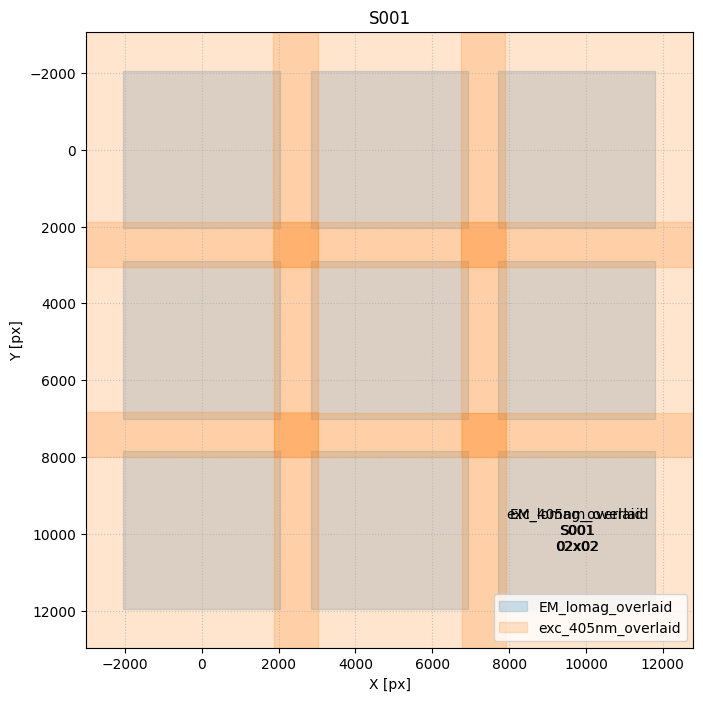

In [14]:
# Choose stacks to plot
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
stacks_2_plot = [stack for stack in stacks if 'overlaid' in stack]

# Plot tile maps
plot_tile_map(stacks=stacks_2_plot,
              render=render)

### Render images

  0%|          | 0/2 [00:00<?, ?it/s]

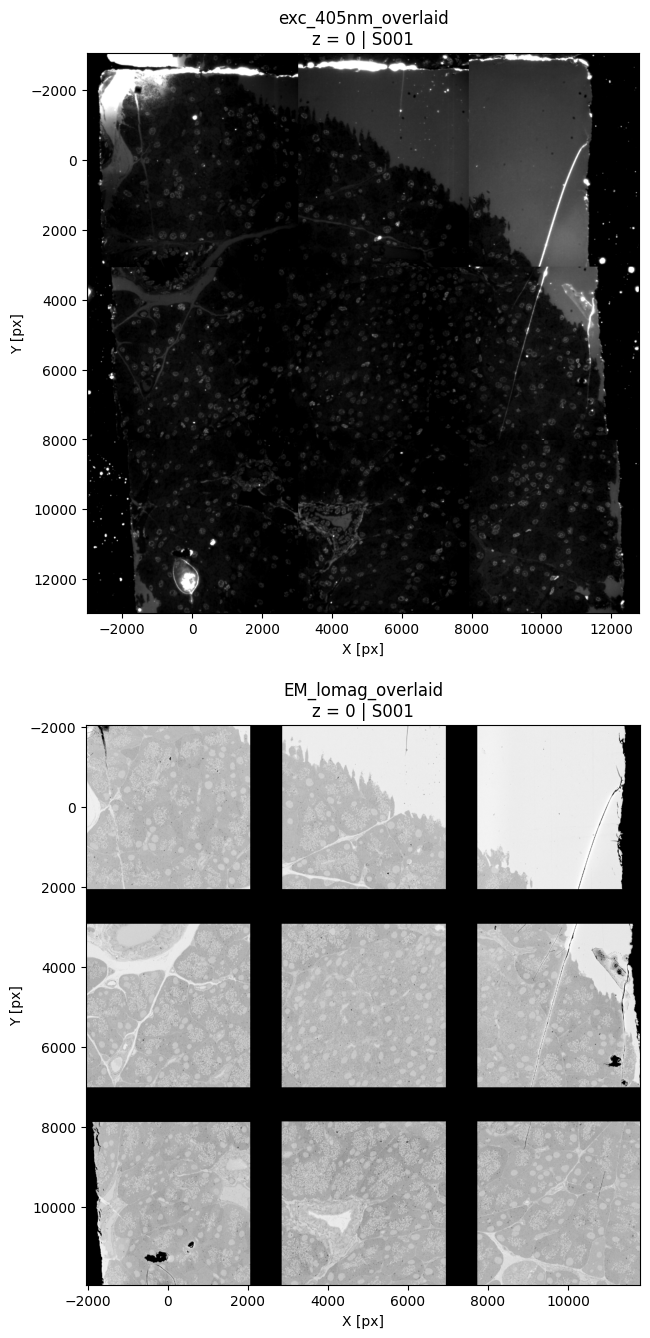

In [15]:
# Specify stacks and sections
stacks_2_plot = stacks_overlaid

# Plot stacks
plot_stacks(stacks=stacks_overlaid,
            render=render)

In [16]:
stacks_overlaid

['exc_405nm_overlaid', 'EM_lomag_overlaid']